# COMP4448 Final Project - Andrew Graham

- Contents

## Notebook Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msno

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import model_selection
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report


# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = 'all'


## Data Preperation

In [2]:
# Load data csv
tv = pd.read_csv('TV16.csv', index_col=0)


In [3]:
tv.shape

(64600, 21)

In [4]:
tv.head(5)

,uid,state,votetrump,age,female,collegeed,racef,famincr,ideo,pid7na,...,religimp,churchatd,prayerfreq,angryracism,whiteadv,fearraces,racerare,lrelig,lcograc,lemprac
1,1,New Hampshire,1.0,47,1,0,White,NaN,3.0,5.0,...,3.0,1.0,3.0,2.0,3.0,1.0,3.0,-0.191681,0.475294,-0.138715
2,2,Louisiana,1.0,22,1,0,White,6.0,3.0,4.0,...,NaN,NaN,NaN,1.0,4.0,1.0,1.0,NaN,-0.185682,-0.619427
3,3,Missouri,NaN,52,1,0,Black,4.0,5.0,1.0,...,4.0,4.0,5.0,NaN,NaN,NaN,NaN,0.573060,NaN,NaN
4,4,Alabama,NaN,28,1,0,Black,1.0,4.0,4.0,...,3.0,3.0,5.0,NaN,NaN,NaN,NaN,0.069356,NaN,NaN
5,5,Colorado,0.0,34,1,1,White,7.0,2.0,2.0,...,1.0,1.0,2.0,2.0,1.0,1.0,1.0,-1.130175,-1.204085,-0.138715


In [5]:
# drop uid as it is same as index
tv = tv.drop(columns='uid')

# drop calculated columns
tv = tv.drop(columns=['lrelig','lcograc','lemprac'])


# drop duplicates
tv = tv.drop_duplicates()

# drop rows containing NA in the target variable
tv = tv.dropna(axis=0, subset=['votetrump'])

In [6]:
tv.shape

(44898, 17)

In [7]:
tv.head(5)

,state,votetrump,age,female,collegeed,racef,famincr,ideo,pid7na,bornagain,religimp,churchatd,prayerfreq,angryracism,whiteadv,fearraces,racerare
1,New Hampshire,1.0,47,1,0,White,NaN,3.0,5.0,0.0,3.0,1.0,3.0,2.0,3.0,1.0,3.0
2,Louisiana,1.0,22,1,0,White,6.0,3.0,4.0,NaN,NaN,NaN,NaN,1.0,4.0,1.0,1.0
5,Colorado,0.0,34,1,1,White,7.0,2.0,2.0,0.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0
7,Texas,1.0,54,0,0,White,3.0,5.0,6.0,1.0,4.0,5.0,7.0,2.0,5.0,2.0,2.0
9,Georgia,1.0,53,0,0,White,4.0,4.0,7.0,1.0,2.0,3.0,6.0,3.0,4.0,1.0,2.0


In [8]:
feature_labels = {'age': {'desc': 'Age of Respodent', 'labels': 'NA'},
        'female': {'desc': 'Sex', 'labels': ['Male','Female']},
        'collegeed': {'desc': 'College Degree Status', 'labels': ['No College Degree','Has College Degree']},
        'bornagain': {'desc': 'Born Again Christian', 'labels': ['Not Born Again Christian','Born Again Cristian']},
        'votetrump': {'desc': 'Vote for Trump', 'labels': ['Did Not Vote for Trump','Voted for Trump']},
        'state': {'desc': 'State of Residence', 'labels': 'NA'},
        'racef': {'desc': 'Race of Respondent', 'labels': 'NA'},
        'famincr': {'desc': 'Household Income', 'labels': ['Less than $10,000','$10,000 - $19,999','$20,000 - $29,999','$30,000 - $39,999','$40,000 - $49,999','$50,000 - $59,999','$60,000 - $69,999','$70,000 - $79,999','$80,000 - $99,999','$100,000 - $119,999','$120,000 - $149,999','$150,000  or more']},
        'ideo': {'desc': 'Ideology', 'labels': ['Very Liberal','Liberal','Moderate','Conservative','Very Conservative']},
        'pid7na': {'desc': 'Partisanship', 'labels': ['Strong Democrat','Not very Strong Democrat','Lean Democrat','Independent','Lean Republican','Not very Strong Republican','Strong Republican']},
        'religimp': {'desc': 'Importance of Religion', 'labels': ['Not at All Important','Not too Important','Somewhat Important','Very Important']},
        'churchatd': {'desc': 'Church Attendance', 'labels': ['Never','Seldom','A few times a year','Once or twice a month','Once a week','More than once a week']},
        'prayerfreq': {'desc': 'Prayer Frequency', 'labels': ['Never','Seldom','A few times a month','Once a week','A few times a week','Once a day','Several times a day']},
        'angryracism': {'desc': 'Angry That Racism Exists', 'labels': ['Strongly agree','Somewhat agree','Neither agree nor disagree','Somewhat disagree','Strongly disagree']},
        'whiteadv': {'desc': 'White People Have Advantages Over Others', 'labels': ['Strongly agree','Somewhat agree','Neither agree nor disagree','Somewhat disagree','Strongly disagree']},
        'fearraces': {'desc': 'Fears Other Races', 'labels': ['Strongly Disagree','Somewhat disagree','Neither agree nor disagree','Somewhat agree','Strongly agree']},
        'racerare': {'desc': 'Racism is Rare in the US', 'labels': ['Strongly Disagree','Somewhat disagree','Neither agree nor disagree','Somewhat agree','Strongly agree']}}

## Data Cleaning

In [9]:
# Check Traget Balance
tv.groupby('votetrump')['votetrump'].count()

c = tv['votetrump'].count()
yv = tv['votetrump'].sum()

print("Vote Trump")
print("Yes: ", yv/c)
print("No: ", 1-(yv/c))


Vote Trump
Yes:  0.4175018931800971
No:  0.5824981068199029


In [10]:
# Check possible values
for col in tv.columns:
    print(col,': ', tv[col].unique())

state :  ['New Hampshire' 'Louisiana' 'Colorado' 'Texas' 'Georgia' 'Pennsylvania'
 'Hawaii' 'Kansas' 'New York' 'Florida' 'Massachusetts' 'Maine' 'Maryland'
 'Michigan' 'Oregon' 'Montana' 'Arizona' 'Washington' 'California'
 'South Carolina' 'Nevada' 'New Jersey' 'West Virginia' 'Oklahoma'
 'Indiana' 'North Carolina' 'Wisconsin' 'Missouri' 'Ohio' 'Utah' 'Wyoming'
 'District of Columbia' 'Illinois' 'Idaho' 'Virginia' 'Minnesota'
 'Alabama' 'Connecticut' 'Nebraska' 'Tennessee' 'Alaska' 'Kentucky' 'Iowa'
 'Rhode Island' 'New Mexico' 'South Dakota' 'Arkansas' 'North Dakota'
 'Vermont' 'Mississippi' 'Delaware']
votetrump :  [1. 0.]
age :  [47 22 34 54 53 59 70 31 28 58 71 76 60 35 56 38 57 49 62 45 64 52 74 77
 82 72 41 50 68 55 46 24 63 36 26 42 33 61 51 39 37 30 79 80 65 69 29 19
 66 75 67 40 78 85 27 48 81 73 21 84 89 43 83 32 44 93 25 91 20 86 87 88
 92 23 18 95 90 94]
female :  [1 0]
collegeed :  [0 1]
racef :  ['White' 'Asian' 'Mixed' 'Other' 'Hispanic' 'Native American' 'Black'
 'Mid

NA data is classified correctly. Data looks clean from misspellings or similar values

### NA Data

In [11]:
#Check NA values
number_missing = tv.isna().sum()
percent_missing = tv.isna().sum() * 100 / len(tv)
missing_value_df = pd.DataFrame({'number_missing': number_missing,
                                 'percent_missing': percent_missing})

missing_value_df

,number_missing,percent_missing
state,0,0.000000
votetrump,0,0.000000
age,0,0.000000
female,0,0.000000
collegeed,0,0.000000
racef,0,0.000000
famincr,4717,10.506036
ideo,1501,3.343133
pid7na,611,1.360862
bornagain,22,0.049000


Features with NA values are all less than 5% of total values with the exception of 'famincr' with 10%.  

<AxesSubplot:>

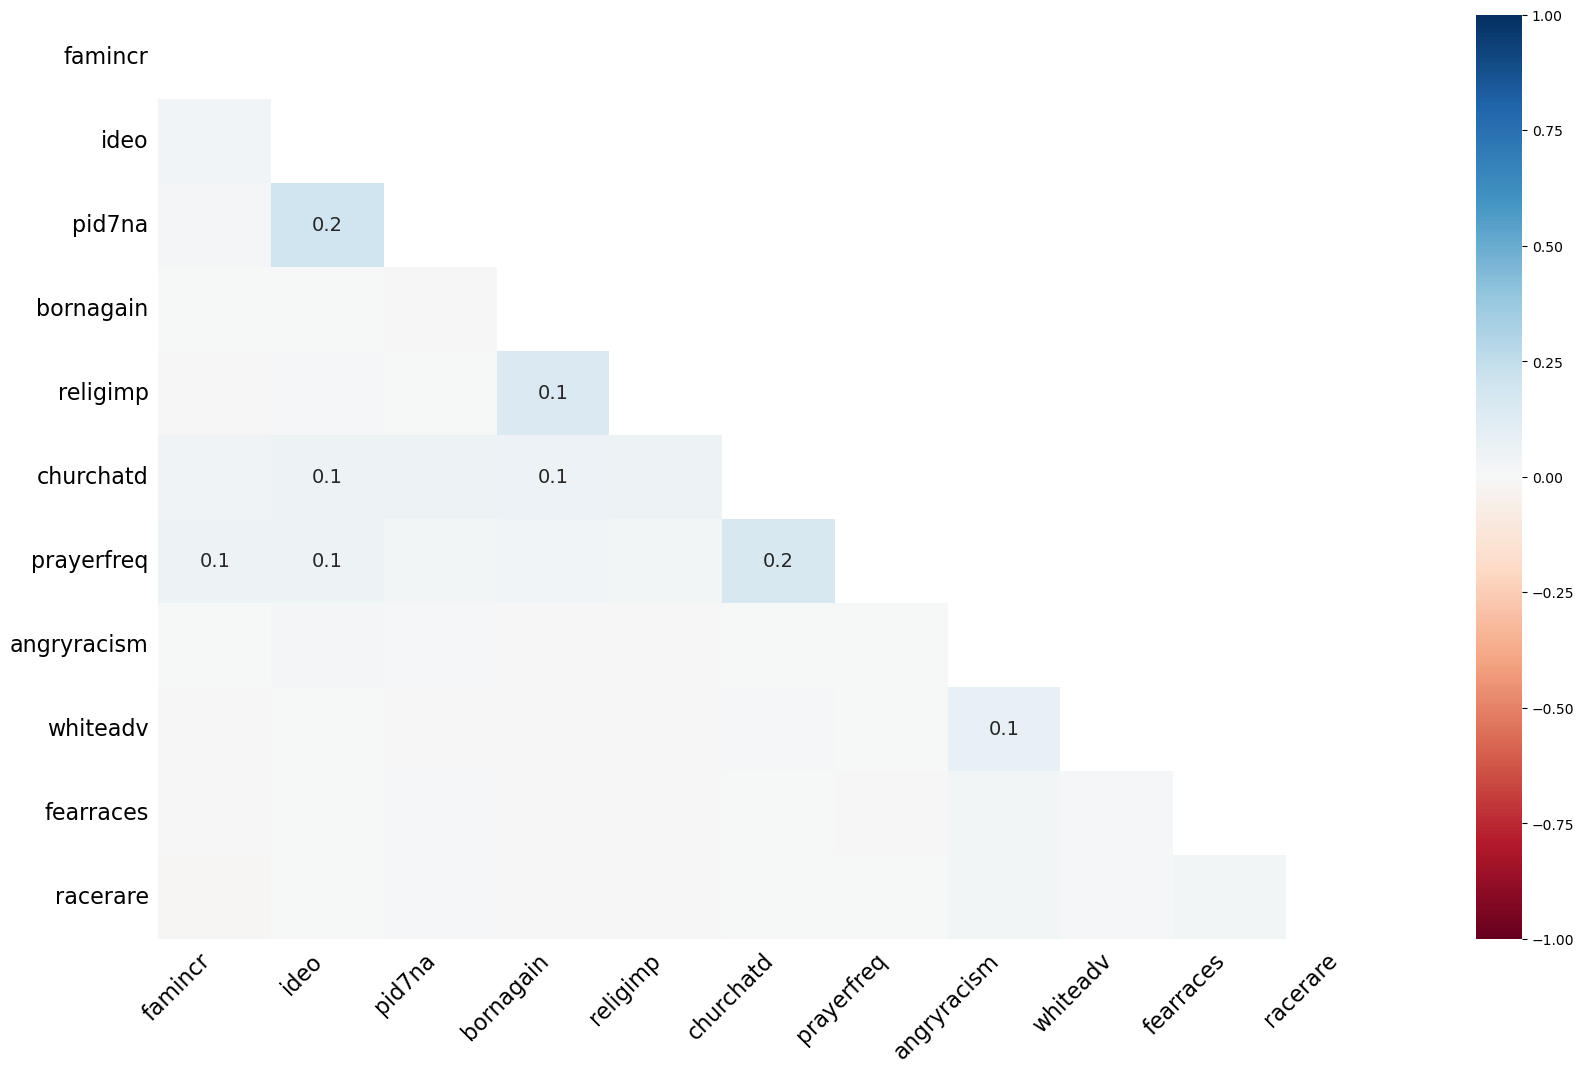

In [12]:
msno.heatmap(tv)

NA from features so no significant correlation

<AxesSubplot:>

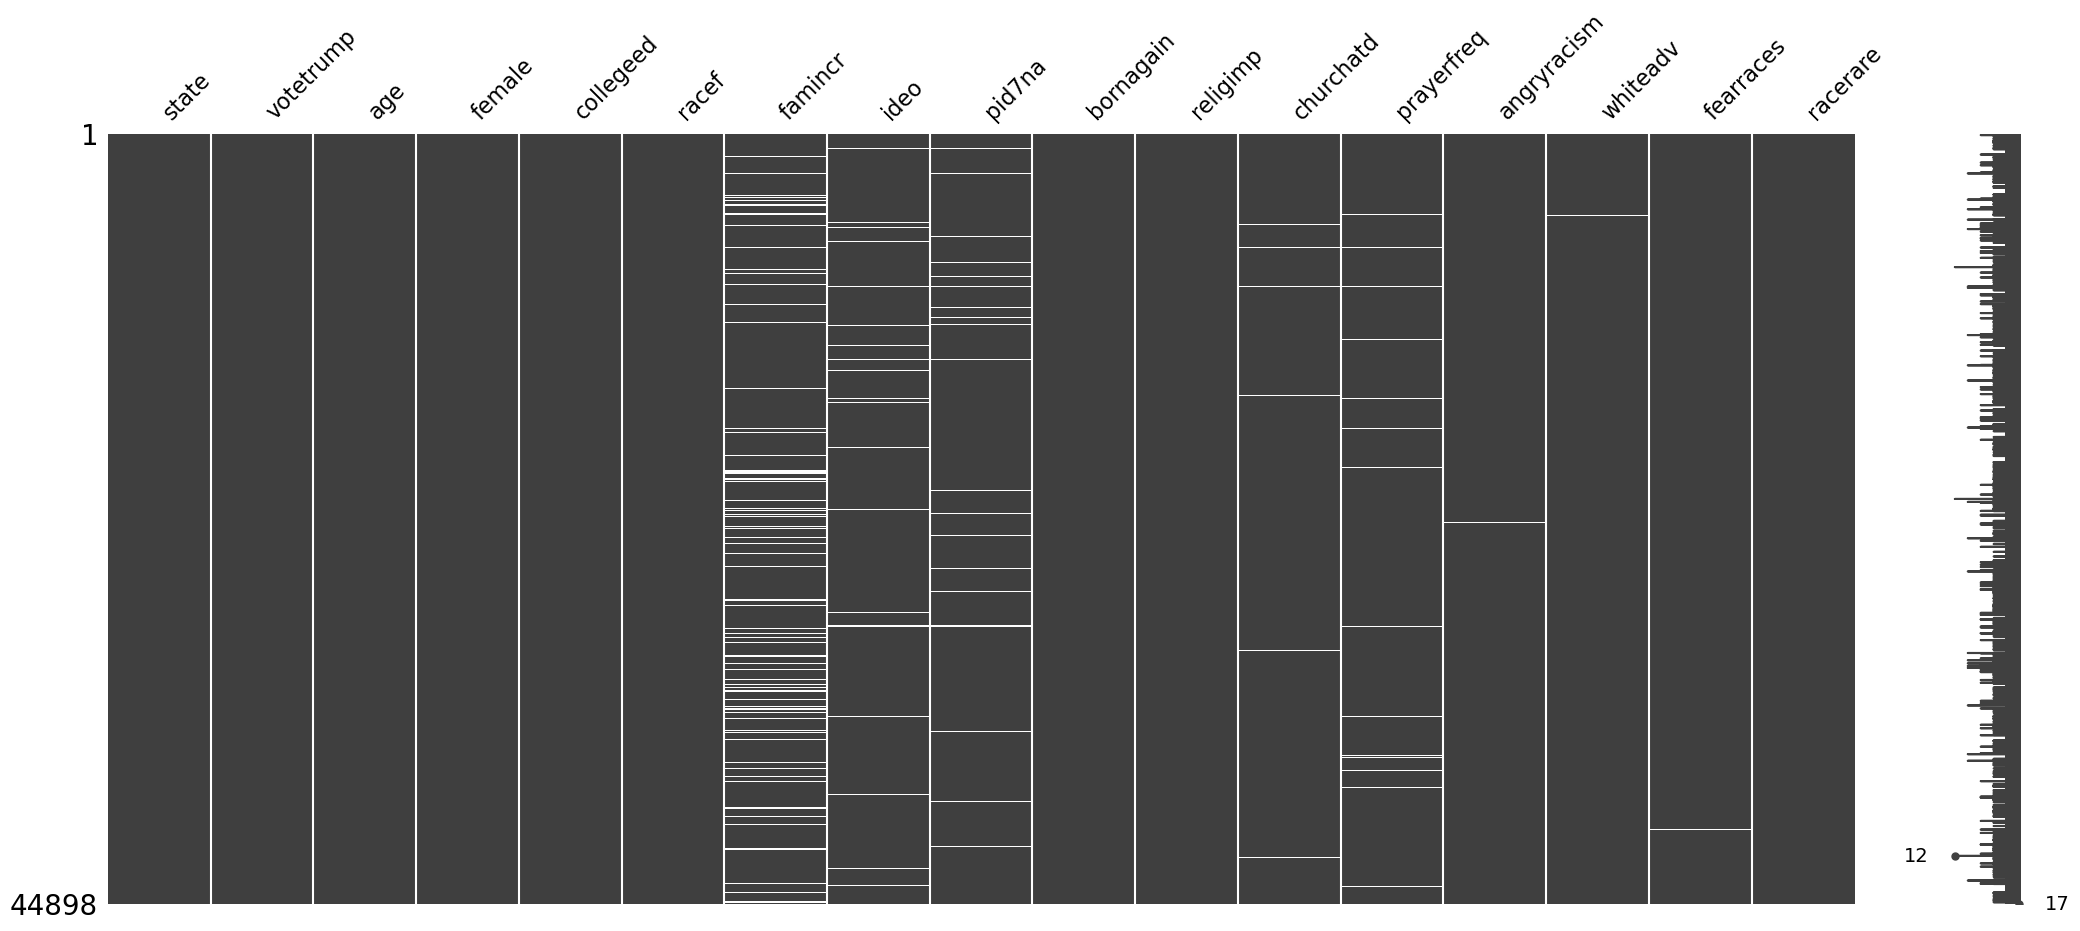

In [13]:
# Look at NA missing distriution
msno.matrix(tv.sort_values(by='votetrump'),)

In [14]:
# Check NA balance to Target Variable
tv_na = tv.drop(columns='votetrump').isna()
tv_na['votetrump'] = tv['votetrump']
tv_na.groupby(['votetrump']).sum().transpose()

votetrump,0.0,1.0
state,0,0
age,0,0
female,0,0
collegeed,0,0
racef,0,0
famincr,2361,2356
ideo,933,568
pid7na,337,274
bornagain,10,12
religimp,11,9


NA looks randomly distributed based on target variable.  Based on this we can delete NA values

In [15]:
# Remove NA
tv = tv.dropna()
tv.shape

(37561, 17)

## Exploritory Data Analysis

In [16]:
# Creating Data Groups 

# Features By Type

target = ['votetrump']
continuous = ['age']
nominal_binary = ['female','collegeed','bornagain']
nominal_multi = ['state','racef']
ordinal = ['famincr','ideo','pid7na','religimp','churchatd','prayerfreq','angryracism','whiteadv','fearraces','racerare']

# Features by theme
demographic_continuous = ['age']
demographic_nominal = ['female','collegeed','racef','famincr']

location = ['state']

ideology = ['ideo','pid7na']
religion = ['bornagain','religimp','churchatd','prayerfreq']
racism = ['angryracism','whiteadv','fearraces','racerare']

In [17]:
# Custom bar plot
def custom_barstack(data, x_name, hue, ax=None):
    
    x_desc = feature_labels[data[x_name].name]['desc']
    x_labels = feature_labels[data[x_name].name]['labels']

    target_name = feature_labels[hue]['desc']
    target_lables = feature_labels[hue]['labels']

    df = data.groupby(x_name)[hue].value_counts().unstack().sort_index()
       
    if ax is None:
        ax = plt.gca()

    ax.bar(df.index, df[0], label = target_lables[0]) 
    ax.bar(df.index, df[1], bottom = df[0], label = target_lables[1]) 

    title = x_desc
    ax.set_title(title)
    ax.set_ylabel('Count')

    ax.set_xticks(df.index)   
    
    if x_labels != 'NA':
        ax.set_xticklabels(x_labels, rotation = 75)
    else:
        ax.set_xticklabels(df.index,rotation = 75)

    ax.legend((target_lables), fontsize=12)

    return(ax) 


### Descriptive Statistics

In [18]:
tv.shape

(37561, 17)

In [19]:
tv['votetrump'].sum()/tv['votetrump'].count()

0.40845557892494877

In [20]:
## Correlation
# Fill diagonal and upper half with NaNs
corr = tv.corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(null_color='#f1f1f1')  # Color NaNs grey
 .set_precision(2))

C:\Users\AMGra\AppData\Local\Temp\ipykernel_6844\2593757487.py:7: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  (corr


,votetrump,age,female,collegeed,famincr,ideo,pid7na,bornagain,religimp,churchatd,prayerfreq,angryracism,whiteadv,fearraces,racerare
votetrump,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
age,0.18,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
female,-0.08,-0.10,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
collegeed,-0.15,-0.16,-0.07,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
famincr,-0.00,-0.04,-0.16,0.34,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
ideo,0.60,0.18,-0.08,-0.14,-0.01,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
pid7na,0.73,0.12,-0.08,-0.10,0.03,0.66,nan,nan,nan,nan,nan,nan,nan,nan,nan
bornagain,0.23,0.03,0.04,-0.11,-0.11,0.32,0.21,nan,nan,nan,nan,nan,nan,nan,nan
religimp,0.29,0.13,0.10,-0.10,-0.08,0.40,0.26,0.50,nan,nan,nan,nan,nan,nan,nan
churchatd,0.20,0.05,0.03,0.03,0.02,0.34,0.21,0.48,0.72,nan,nan,nan,nan,nan,nan


>#### Age

Text(0.5, 0.98, 'Votes for Trump based on Age')

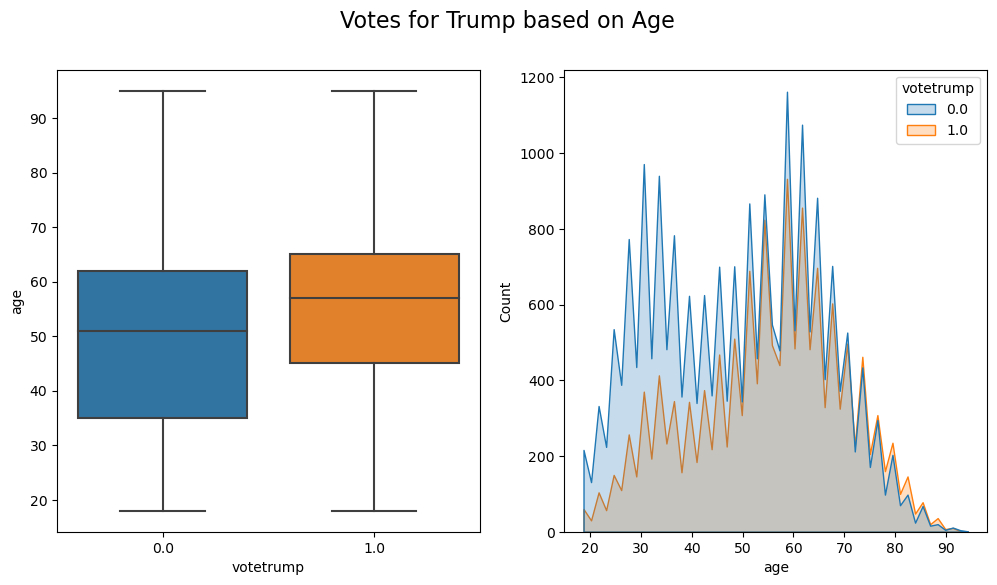

In [21]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12,6))
sns.boxplot(data=tv, x='votetrump',y='age', ax=ax1)
sns.histplot(data=tv, x='age', hue='votetrump',element="poly", ax = ax2)
fig.suptitle('Votes for Trump based on Age', fontsize=16)

>#### State

In [22]:
import geopandas as gpd


In [23]:
states_geo = gpd.read_file('us-states.json')
tv_states = tv[['votetrump','state']]

In [24]:
tv_states = tv_states.groupby('state',as_index=False).sum().merge(tv_states.groupby('state',as_index=False).count(),how='left',on='state')
tv_states['vtp'] = tv_states['votetrump_x']/tv_states['votetrump_y']
tv_states

,state,votetrump_x,votetrump_y,vtp
0,Alabama,193.0,401,0.481297
1,Alaska,30.0,70,0.428571
2,Arizona,425.0,895,0.474860
3,Arkansas,141.0,279,0.505376
4,California,1145.0,3494,0.327705
5,Colorado,269.0,679,0.396171
6,Connecticut,148.0,398,0.371859
7,Delaware,57.0,154,0.370130
8,District of Columbia,10.0,117,0.085470
9,Florida,1316.0,2914,0.451613


In [25]:
#join tables to get geometry
tv_states = tv_states.merge(states_geo[['name','geometry']], how='left', left_on='state', right_on='name')
tv_states = tv_states.drop(columns='name')
tv_states

,state,votetrump_x,votetrump_y,vtp,geometry
0,Alabama,193.0,401,0.481297,"POLYGON ((-87.359 35.001, -85.607 34.985, -85...."
1,Alaska,30.0,70,0.428571,"MULTIPOLYGON (((-131.602 55.118, -131.569 55.2..."
2,Arizona,425.0,895,0.474860,"POLYGON ((-109.043 37.000, -109.048 31.332, -1..."
3,Arkansas,141.0,279,0.505376,"POLYGON ((-94.474 36.502, -90.153 36.496, -90...."
4,California,1145.0,3494,0.327705,"POLYGON ((-123.233 42.006, -122.379 42.012, -1..."
5,Colorado,269.0,679,0.396171,"POLYGON ((-107.920 41.004, -105.729 40.998, -1..."
6,Connecticut,148.0,398,0.371859,"POLYGON ((-73.054 42.039, -71.799 42.023, -71...."
7,Delaware,57.0,154,0.370130,"POLYGON ((-75.414 39.804, -75.507 39.684, -75...."
8,District of Columbia,10.0,117,0.085470,"POLYGON ((-77.035 38.994, -76.909 38.895, -77...."
9,Florida,1316.0,2914,0.451613,"POLYGON ((-85.497 30.998, -85.004 31.003, -84...."


In [26]:
tv_states_gp = gpd.GeoDataFrame(tv_states, geometry='geometry')

In [27]:
# plotting function

def plot_map(df,column, cmap, title, ax):
    df.boundary.plot(edgecolor='black',  # plots boundaries of features
                     linewidth=0.7,
                     ax=ax)

    map = df.plot(column=column, # plots data with has for NA
                cmap=cmap,
                legend=True,
                scheme='Quantiles',
                legend_kwds={'loc': 'lower right'},
                ax=ax)

    ax.set_title(title) #sets title
    # turning axis off
    ax.set_axis_off() #remove axis

    #set legend
    leg = map.get_legend()
    leg._loc = 4

    # change format of legend
    for lbl in leg.get_texts():
        label_text = lbl.get_text().split()
        lower = label_text[0]
        if lower == 'Missing':
            new_text = 'Missing Data'
        else:
            lower = lower[:4]
            upper = label_text[1][:4]

            new_text = f'{lower} - {upper}'
        lbl.set_text(new_text)

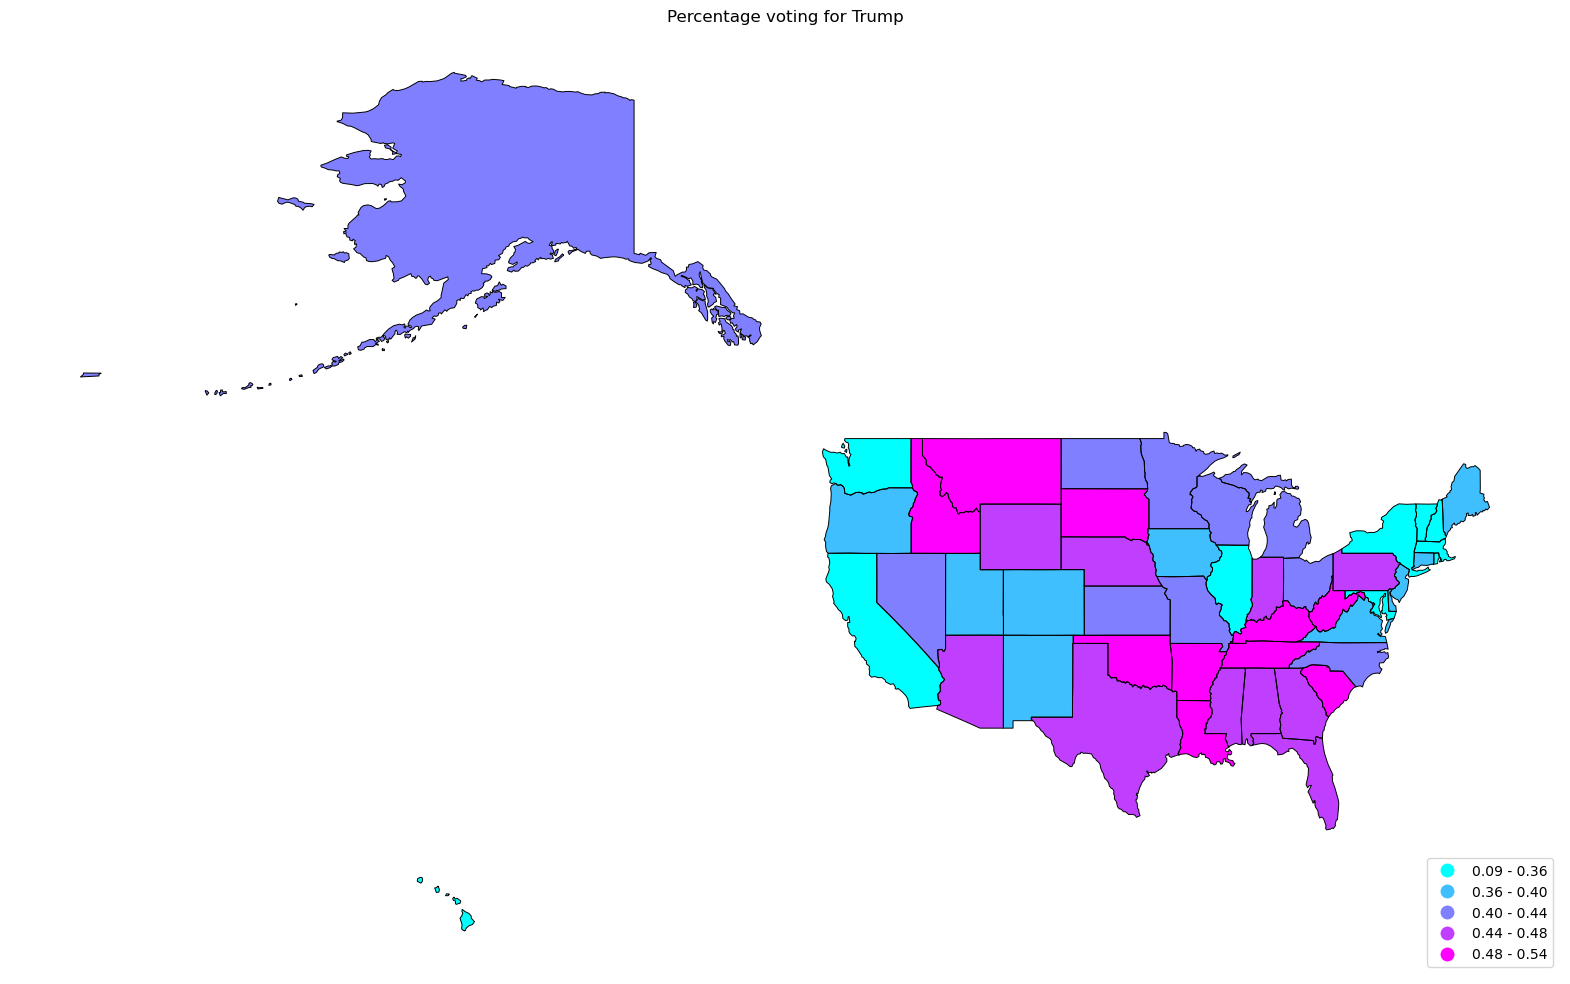

In [28]:
fig, ax = plt.subplots(figsize=(20,20))
plot_map(tv_states_gp,'vtp', 'cool', "Percentage voting for Trump", ax)

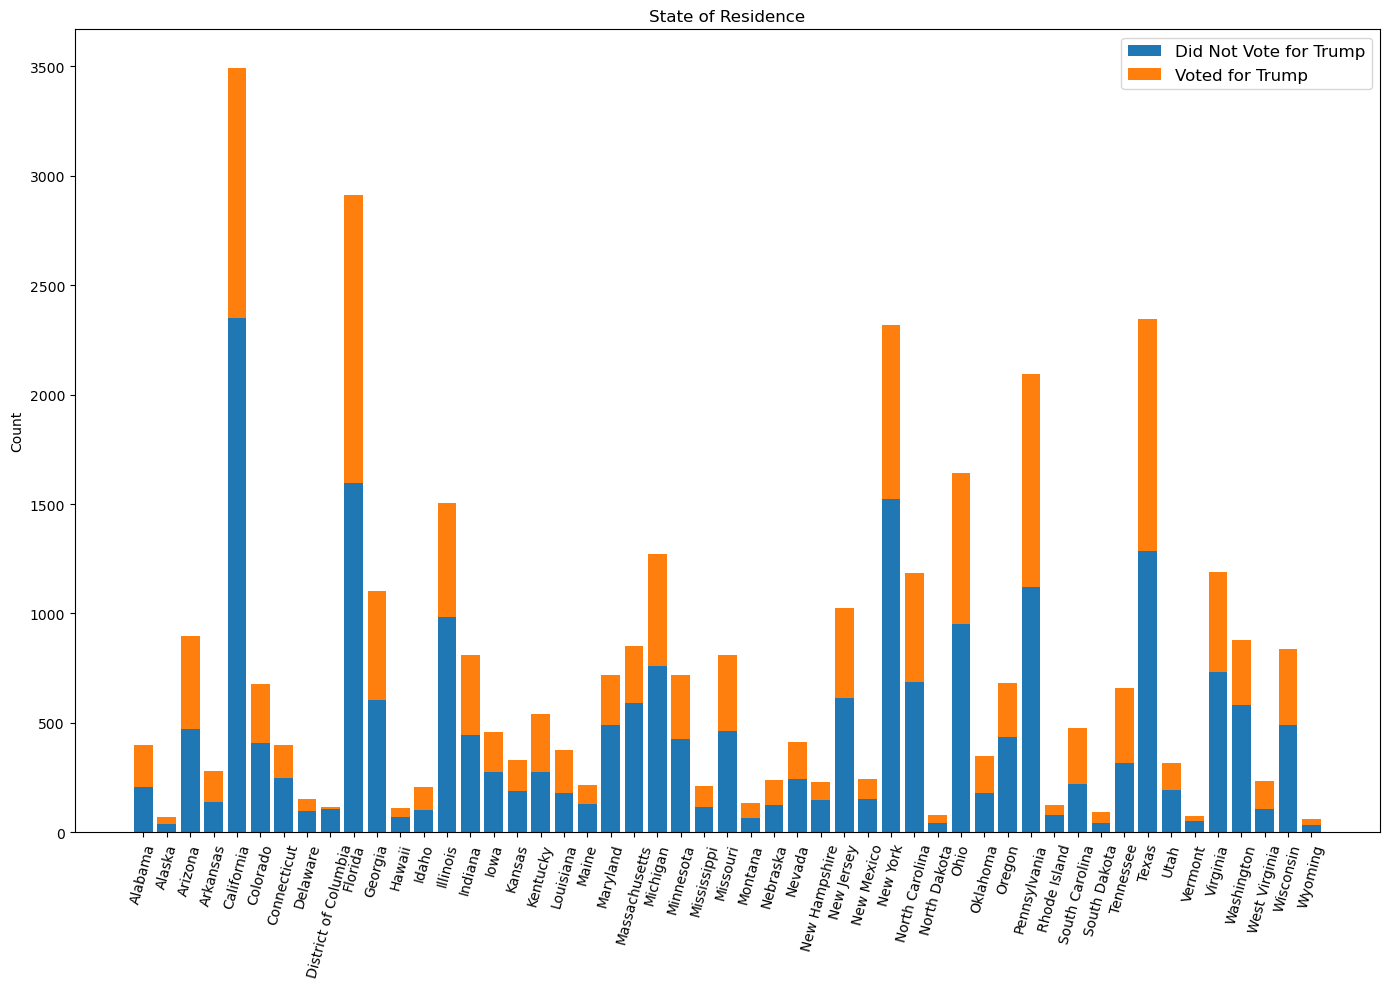

In [29]:
fig, ax = plt.subplots(figsize=(14,10))

custom_barstack(tv, 'state', 'votetrump', ax=ax)

plt.tight_layout()
plt.show()

> #### Sex, College Educated, Race, Household Income

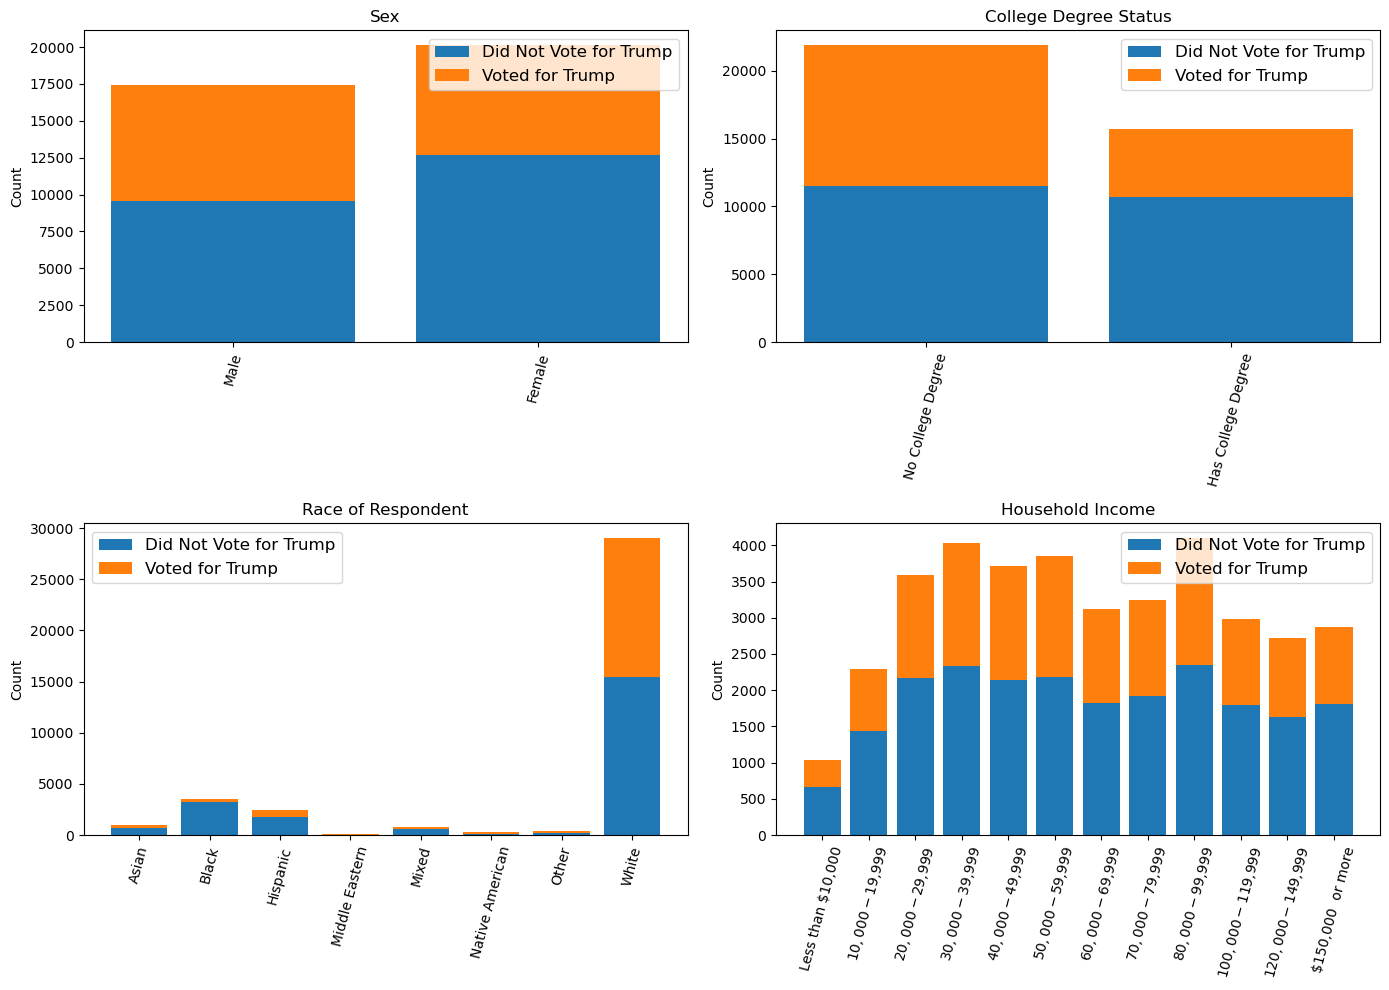

In [30]:
fig, axes = plt.subplots(2,2,figsize=(14,10))

for i, ax in enumerate(axes.flat):
    custom_barstack(tv, demographic_nominal[i], 'votetrump', ax=ax)

plt.tight_layout()
plt.show()

> #### Ideology

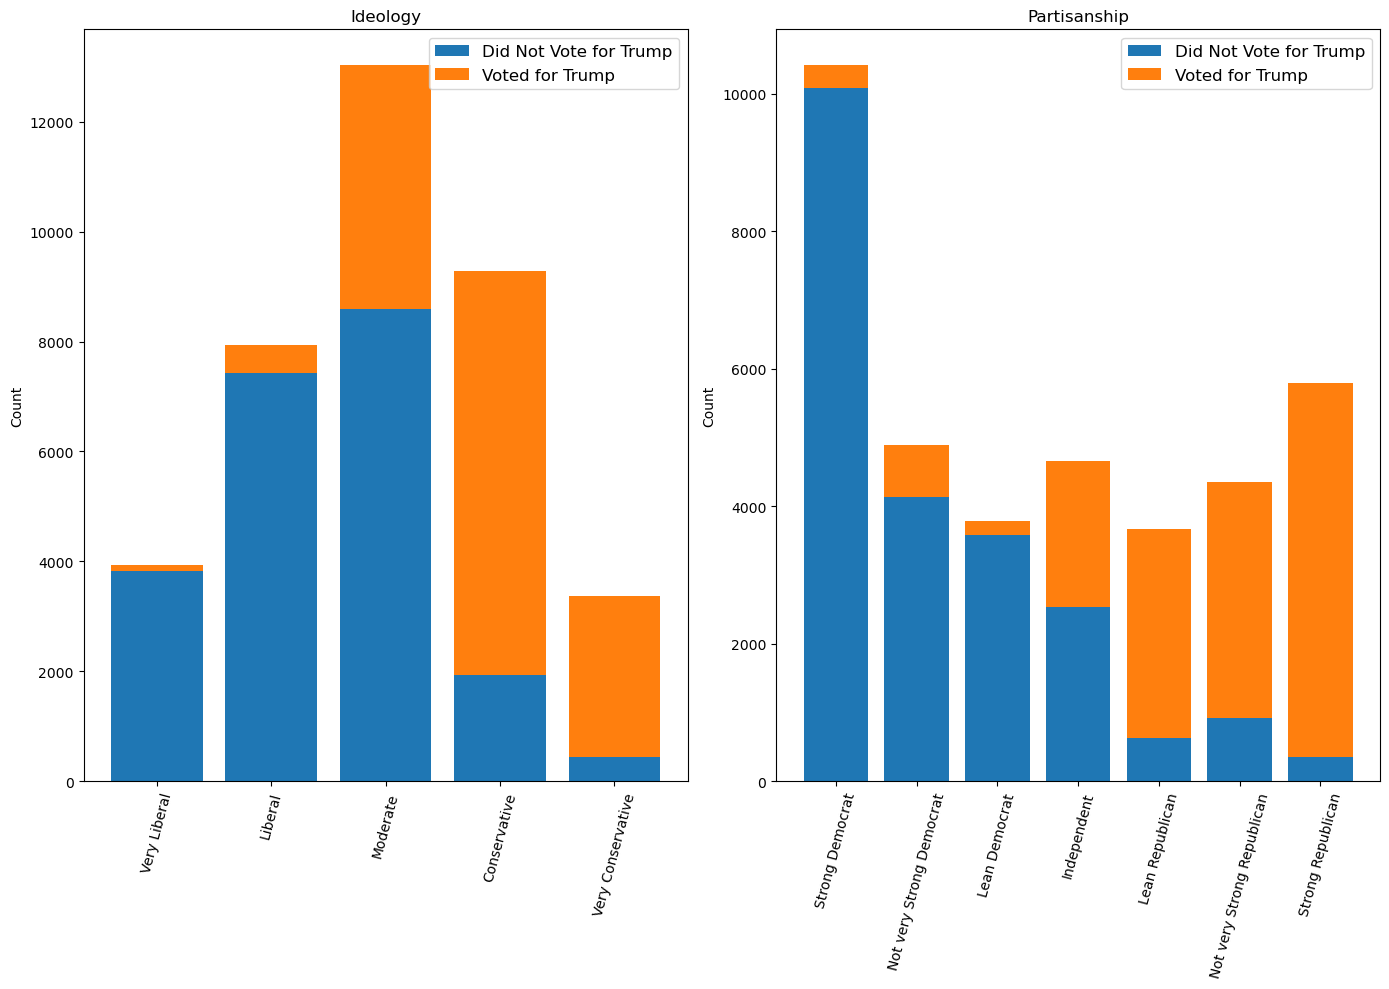

In [31]:
fig, axes = plt.subplots(1,2,figsize=(14,10))

for i, ax in enumerate(axes.flat):
    custom_barstack(tv, ideology[i], 'votetrump', ax=ax)

plt.tight_layout()
plt.show()

> #### Religion

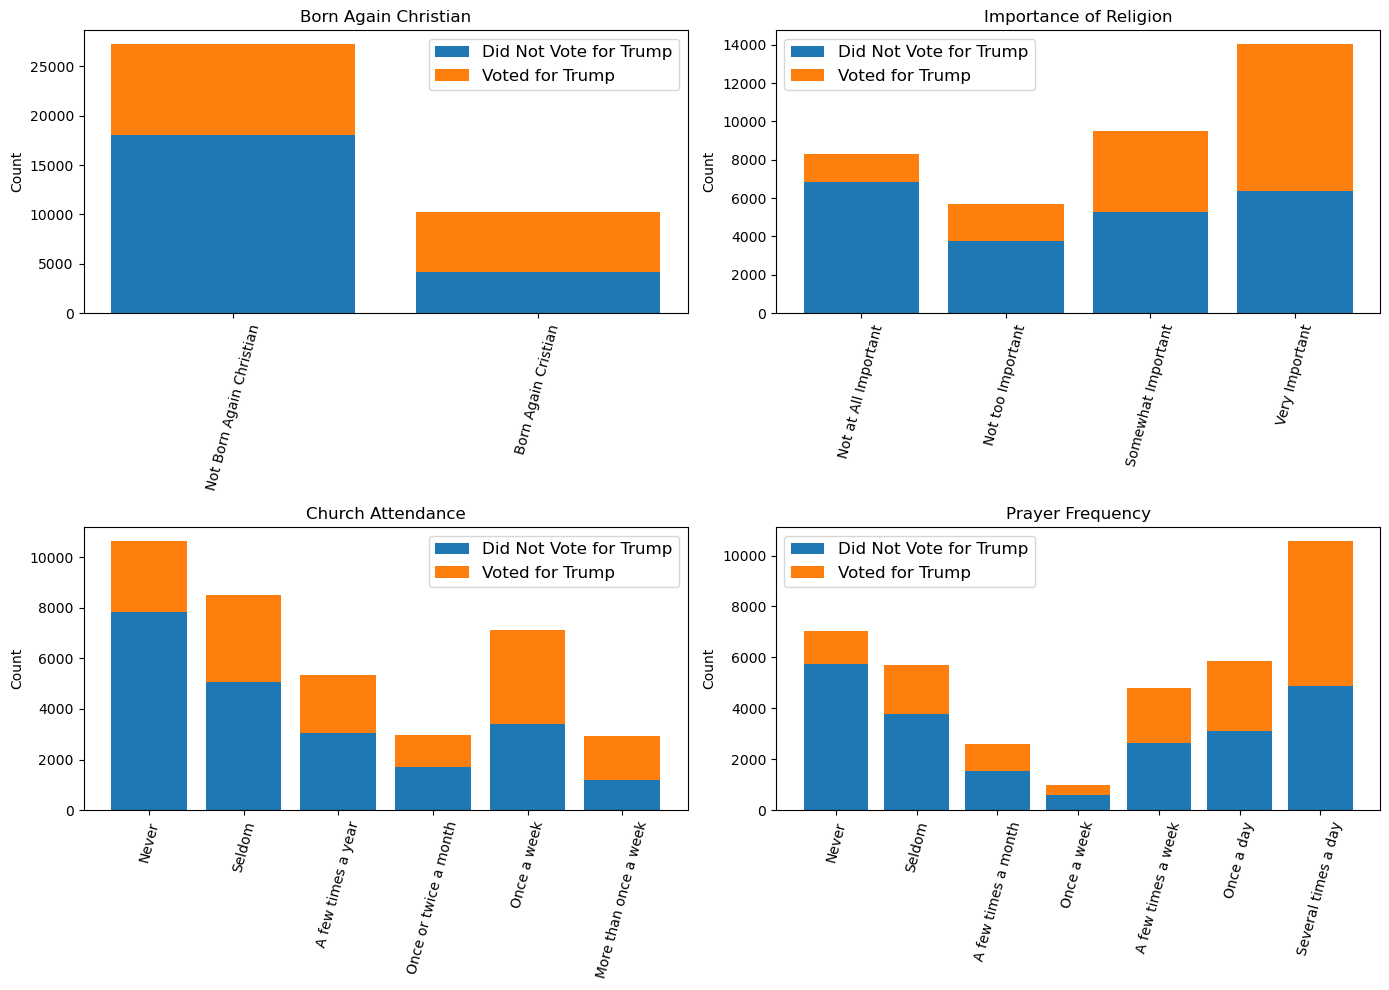

In [32]:
fig, axes = plt.subplots(2,2,figsize=(14,10))

for i, ax in enumerate(axes.flat):
    custom_barstack(tv, religion[i], 'votetrump', ax=ax)

plt.tight_layout()
plt.show()

> #### Views on Racism

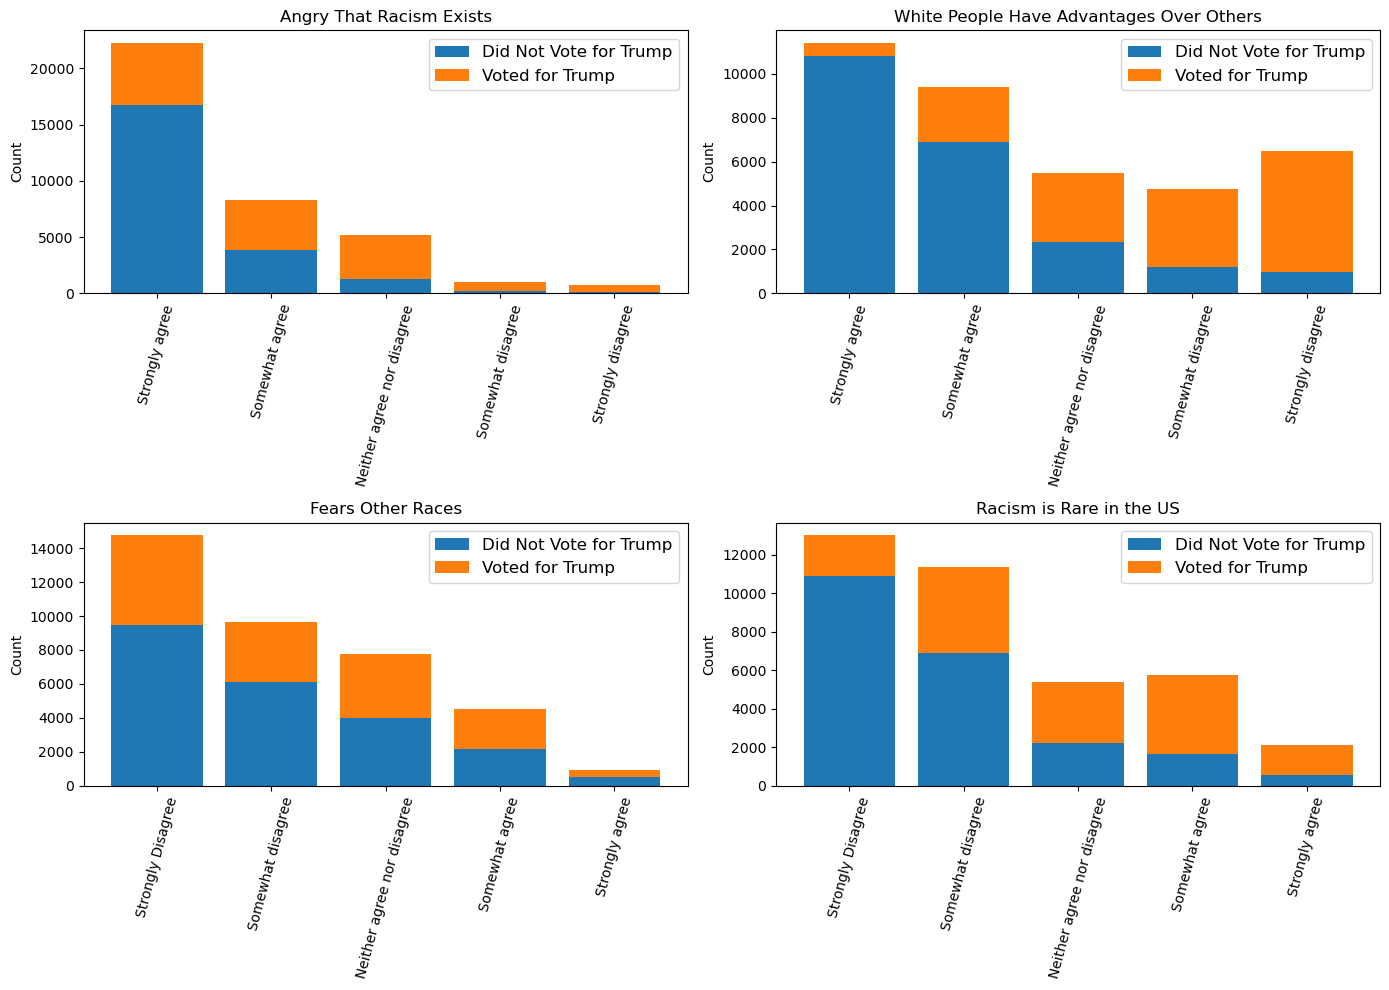

In [33]:
fig, axes = plt.subplots(2,2,figsize=(14,10))

for i, ax in enumerate(axes.flat):
    custom_barstack(tv, racism[i], 'votetrump', ax=ax)

plt.tight_layout()
plt.show()

## Data Preperation

In [34]:
tv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37561 entries, 5 to 64454
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   state        37561 non-null  object 
 1   votetrump    37561 non-null  float64
 2   age          37561 non-null  int64  
 3   female       37561 non-null  int64  
 4   collegeed    37561 non-null  int64  
 5   racef        37561 non-null  object 
 6   famincr      37561 non-null  float64
 7   ideo         37561 non-null  float64
 8   pid7na       37561 non-null  float64
 9   bornagain    37561 non-null  float64
 10  religimp     37561 non-null  float64
 11  churchatd    37561 non-null  float64
 12  prayerfreq   37561 non-null  float64
 13  angryracism  37561 non-null  float64
 14  whiteadv     37561 non-null  float64
 15  fearraces    37561 non-null  float64
 16  racerare     37561 non-null  float64
dtypes: float64(12), int64(3), object(2)
memory usage: 5.2+ MB


In [35]:
# Convert types to Category

for col in nominal_binary:
    tv[col] = tv[col].astype('uint8')

for col in nominal_multi:
    tv[col] = tv[col].astype('category')

for col in ordinal:
    tv[col] = tv[col].astype('uint8')

tv['votetrump'] = tv['votetrump'].astype('uint8')
tv.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 37561 entries, 5 to 64454
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   state        37561 non-null  category
 1   votetrump    37561 non-null  uint8   
 2   age          37561 non-null  int64   
 3   female       37561 non-null  uint8   
 4   collegeed    37561 non-null  uint8   
 5   racef        37561 non-null  category
 6   famincr      37561 non-null  uint8   
 7   ideo         37561 non-null  uint8   
 8   pid7na       37561 non-null  uint8   
 9   bornagain    37561 non-null  uint8   
 10  religimp     37561 non-null  uint8   
 11  churchatd    37561 non-null  uint8   
 12  prayerfreq   37561 non-null  uint8   
 13  angryracism  37561 non-null  uint8   
 14  whiteadv     37561 non-null  uint8   
 15  fearraces    37561 non-null  uint8   
 16  racerare     37561 non-null  uint8   
dtypes: category(2), int64(1), uint8(14)
memory usage: 1.1 MB


### Feature Engineering

In [36]:
# One-hot encoding for stae and race
tv = pd.get_dummies(tv, columns=['racef','state'])

In [37]:
# binning age
tv['age_bin'] = pd.cut(tv['age'], [0, 35, 51, 70, 120])
tv = tv.drop(columns='age')
tv = pd.get_dummies(tv, columns=['age_bin'])

In [38]:
tv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37561 entries, 5 to 64454
Data columns (total 77 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   votetrump                   37561 non-null  uint8
 1   female                      37561 non-null  uint8
 2   collegeed                   37561 non-null  uint8
 3   famincr                     37561 non-null  uint8
 4   ideo                        37561 non-null  uint8
 5   pid7na                      37561 non-null  uint8
 6   bornagain                   37561 non-null  uint8
 7   religimp                    37561 non-null  uint8
 8   churchatd                   37561 non-null  uint8
 9   prayerfreq                  37561 non-null  uint8
 10  angryracism                 37561 non-null  uint8
 11  whiteadv                    37561 non-null  uint8
 12  fearraces                   37561 non-null  uint8
 13  racerare                    37561 non-null  uint8
 14  racef_

In [39]:
tv

,votetrump,female,collegeed,famincr,ideo,pid7na,bornagain,religimp,churchatd,prayerfreq,...,state_Vermont,state_Virginia,state_Washington,state_West Virginia,state_Wisconsin,state_Wyoming,"age_bin_(0, 35]","age_bin_(35, 51]","age_bin_(51, 70]","age_bin_(70, 120]"
5,0,1,1,7,2,2,0,1,1,2,...,0,0,0,0,0,0,1,0,0,0
7,1,0,0,3,5,6,1,4,5,7,...,0,0,0,0,0,0,0,0,1,0
9,1,0,0,4,4,7,1,2,3,6,...,0,0,0,0,0,0,0,0,1,0
10,1,1,0,7,3,7,0,3,2,4,...,0,0,0,0,0,0,0,0,1,0
11,0,1,1,10,3,2,0,2,2,3,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64443,0,1,0,1,2,1,0,2,1,3,...,0,0,0,0,0,0,1,0,0,0
64444,0,0,0,2,3,4,1,3,2,7,...,0,0,0,0,0,0,0,0,1,0
64446,0,0,0,3,1,1,0,1,1,1,...,0,0,0,0,0,0,0,0,1,0
64448,0,0,0,2,3,1,0,4,5,7,...,0,0,0,0,0,0,0,0,1,0


## Modeling


### Clustering

In [40]:
# Creat clustering copy
tv_clust = tv.copy()

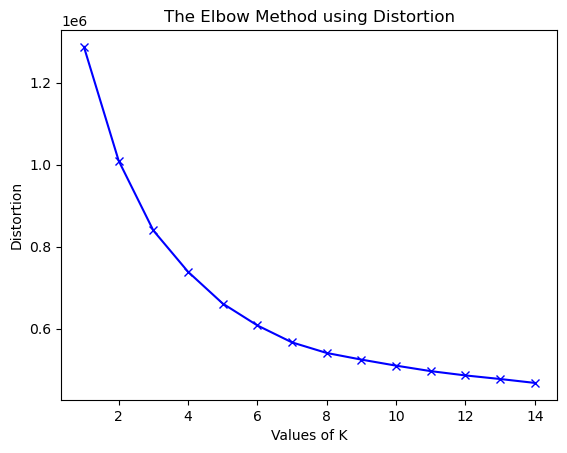

In [41]:
from sklearn.cluster import KMeans
# Elbow curve to find optimal K
distortions = []
K = range(1, 15)
for k in K:
    clustering = KMeans(n_clusters=k, init='k-means++', random_state=42)
    clustering.fit(tv_clust.drop(columns='votetrump'))
    distortions.append(clustering.inertia_)
    
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show();

In [42]:
# Building the model with 3 clusters
kmean = KMeans(n_clusters=6, init='k-means++', random_state=42)
clusters = kmean.fit_predict(tv_clust.drop(columns='votetrump'))
tv_clust.insert(0, "Cluster", clusters, True)
tv_clust

,Cluster,votetrump,female,collegeed,famincr,ideo,pid7na,bornagain,religimp,churchatd,...,state_Vermont,state_Virginia,state_Washington,state_West Virginia,state_Wisconsin,state_Wyoming,"age_bin_(0, 35]","age_bin_(35, 51]","age_bin_(51, 70]","age_bin_(70, 120]"
5,1,0,1,1,7,2,2,0,1,1,...,0,0,0,0,0,0,1,0,0,0
7,4,1,0,0,3,5,6,1,4,5,...,0,0,0,0,0,0,0,0,1,0
9,4,1,0,0,4,4,7,1,2,3,...,0,0,0,0,0,0,0,0,1,0
10,0,1,1,0,7,3,7,0,3,2,...,0,0,0,0,0,0,0,0,1,0
11,1,0,1,1,10,3,2,0,2,2,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64443,2,0,1,0,1,2,1,0,2,1,...,0,0,0,0,0,0,1,0,0,0
64444,3,0,0,0,2,3,4,1,3,2,...,0,0,0,0,0,0,0,0,1,0
64446,2,0,0,0,3,1,1,0,1,1,...,0,0,0,0,0,0,0,0,1,0
64448,3,0,0,0,2,3,1,0,4,5,...,0,0,0,0,0,0,0,0,1,0


### Data Splitting

In [43]:
from sklearn.model_selection import train_test_split

# Non Cluster
X = tv.drop(columns=['votetrump'])
y = tv['votetrump']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 32)


# Cluster
X_clust = tv_clust.drop(columns=['votetrump'])
y_clust = tv_clust['votetrump']

X_train_clust, X_test_clust, y_train, y_test = train_test_split(X_clust, y_clust, test_size = 0.20, random_state = 32)

In [610]:
def run_exps(X_train: pd.DataFrame , y_train: pd.DataFrame, X_test: pd.DataFrame, y_test: pd.DataFrame) -> pd.DataFrame:
    '''
    Lightweight script to test many models and find winners
        :param X_train: training split
    :param y_train: training target vector
    :param X_test: test split
    :param y_test: test target vector
    :return: DataFrame of predictions
    '''
    
    dfs = []
    models = [
          ('LogReg', LogisticRegression(max_iter= 10000)), 
          ('RF', RandomForestClassifier()),
          ('KNN', KNeighborsClassifier()), 
          ('GNB', GaussianNB())
        ]
    names = []
    target_names = ['Did Not Vote for Trump', 'Voted for Trump']
    scores = []
    for name, model in models:
        kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=42)
        cv_results = model_selection.cross_validate(model, X_train, y_train, cv=kfold, scoring=['accuracy','f1'])
        clf = model.fit(X_train, y_train)
        y_pred_test = clf.predict(X_test)
        
        scores.append([name,cv_results['test_accuracy'].mean(),accuracy_score(y_test, y_pred_test),
                        cv_results['test_f1'].mean(),f1_score(y_test, y_pred_test)])

    results = pd.DataFrame(data= scores,columns=['Model','Train_Accuracy','Test_Accuracy', 'Train_F1', 'Test_F1'])
    results.sort_values(by=['Test_Accuracy'])

    return results

In [611]:
results = run_exps(X_train, y_train, X_test, y_test)
results.sort_values(by=['Test_Accuracy'], ascending=False)

c:\Users\AMGra\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\Users\AMGra\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

,Model,Train_Accuracy,Test_Accuracy,Train_F1,Test_F1
1,RF,0.892572,0.892054,0.868902,0.867635
0,LogReg,0.890042,0.890057,0.866023,0.865341
2,KNN,0.878794,0.877679,0.852389,0.851126
3,GNB,0.810536,0.815786,0.782754,0.788767


In [612]:
results_clust = run_exps(X_train_clust, y_train, X_test_clust, y_test)
results_clust.sort_values(by=['Test_Accuracy'], ascending=False)

c:\Users\AMGra\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\Users\AMGra\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

,Model,Train_Accuracy,Test_Accuracy,Train_F1,Test_F1
1,RF,0.891440,0.893917,0.867699,0.870343
0,LogReg,0.890675,0.889924,0.866744,0.865331
2,KNN,0.879093,0.878477,0.852876,0.851906
3,GNB,0.812234,0.818315,0.784607,0.791889


### Random Forest Tuning

In [613]:
rf = RandomForestClassifier(n_jobs=14)

param_grid_rf = {'max_depth': [4,8,16],
            'n_estimators':[100,150,200],
            'max_features':['sqrt',1,5,10],
            'min_samples_split': [1,2,4]}


grid_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf,cv=8)
grid_rf = grid_rf.fit(X_train,y_train)


y_pred_train_rf = grid_rf.predict(X_train)
y_pred_test_rf = grid_rf.predict(X_test)

acc_rf = accuracy_score(y_test, y_pred_test_rf)
f1_rf = f1_score(y_test, y_pred_test_rf)

print('\n----- Random Forest ----')
print('Accuracy :',accuracy_score(y_train, y_pred_train_rf))
print('f1 :',f1_score(y_train, y_pred_train_rf))

print('Testing')
print('Accuracy :',acc_rf)
print('f1 :',f1_rf)

c:\Users\AMGra\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
288 fits failed out of a total of 864.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
288 fits failed with the following error:
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "c:\Users\AMGra\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py", line 436, in _process_worker
    r = call_item()
  File "c:\Users\AMGra\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py", line 288, in __call__
    return self.fn(*self.args, **self.kwargs)
  File "c:\Users\AMGra\anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 595, in __call__
    


----- Random Forest ----
Accuracy : 0.9538738019169329
f1 : 0.9440361786319955
Testing
Accuracy : 0.8953813390123786
f1 : 0.8724025974025974


In [614]:
grid_rf.best_params_

{'max_depth': 16,
 'max_features': 10,
 'min_samples_split': 2,
 'n_estimators': 150}

# Logistic Regression

In [45]:
logR = LogisticRegression(max_iter= 10000)

param_grid_logR = {'C' : [0.001,0.01,0.1,1,10,100]}


grid_logR = GridSearchCV(estimator=logR, param_grid=param_grid_logR,cv=8)
grid_logR = grid_logR.fit(X_train,y_train)

y_pred_train_logR = grid_logR.predict(X_train)
y_pred_test_logR = grid_logR.predict(X_test)

acc_logR = accuracy_score(y_test, y_pred_test_logR)
f1_logR = f1_score(y_test, y_pred_test_logR)

print('\n----- Logistic Regression ----')
print('Accuracy :',accuracy_score(y_train, y_pred_train_logR))
print('f1 :',f1_score(y_train, y_pred_train_logR))

print('Testing')
print('Accuracy :',acc_logR)
print('f1 :',f1_logR)


----- Logistic Regression ----
Accuracy : 0.8909078807241747
f1 : 0.8671152910653479
Testing
Accuracy : 0.8885931052841741
f1 : 0.8636141437184293


In [616]:
final_scores = {'Model': ['Random Forest','Log Reg'],
                'Accuracy' : [acc_rf,acc_logR],
                'F1' : [f1_rf,f1_logR]}

final_table = pd.DataFrame(final_scores)

final_table.sort_values(by=['Accuracy'], ascending=False)

,Model,Accuracy,F1
0,Random Forest,0.895381,0.872403
1,Log Reg,0.895381,0.872403


In [624]:
grid_logR.best_params_

{'C': 0.01}